<a href="https://colab.research.google.com/github/theoVasilas/Diplomatic_incident/blob/simulation/Fed_3_cifar10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Installations

In [1]:
!pip install -q flwr[simulation] flwr-datasets[vision] torch torchvision

In [2]:
from collections import OrderedDict, Counter
from typing import Dict, List, Optional, Tuple

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from datasets import load_dataset, logging
from datasets.utils.logging import disable_progress_bar

import flwr
from flwr.client import Client, ClientApp, NumPyClient
from flwr.common import Metrics, Context
from flwr.server import ServerApp, ServerConfig, ServerAppComponents
from flwr.server.strategy import FedAvg, FedAdagrad
from flwr.simulation import run_simulation
from flwr_datasets import FederatedDataset
from flwr.common import ndarrays_to_parameters, NDArrays, Scalar, Context


DEVICE = torch.device("cpu")  # Try "cuda" to train on GPU
print(f"Training on {DEVICE}")
print(f"Flower {flwr.__version__} / PyTorch {torch.__version__}")
disable_progress_bar()

Training on cpu
Flower 1.12.0 / PyTorch 2.5.1+cu121


# Dataloader


In [3]:
BATCH_SIZE = 32
NUM_CLIENTS = 10

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [4]:
def load_datasets(partition_id: int, num_partitions: int):
    fds = FederatedDataset(dataset="cifar10", partitioners={"train": num_partitions})

    pytorch_transforms = transforms.Compose(
        [transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
    )
    def apply_transforms(batch):
        batch["img"] = [pytorch_transforms(img) for img in batch["img"]]
        return batch

    partition = fds.load_partition(partition_id)
    # Divider : 80% train, 20% test
    partition_train_test = partition.train_test_split(test_size=0.2, seed=42)
    #Apply Tranforms
    partition_train_test = partition_train_test.with_transform(apply_transforms)

    trainloader = DataLoader(partition_train_test["train"], batch_size=BATCH_SIZE, shuffle=True )
    valloader = DataLoader(partition_train_test["test"], batch_size=BATCH_SIZE)

    testset = fds.load_split("test").with_transform(apply_transforms)
    testloader = DataLoader(testset, batch_size=BATCH_SIZE)

    return trainloader, valloader, testloader

### Histogram of the dataset


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


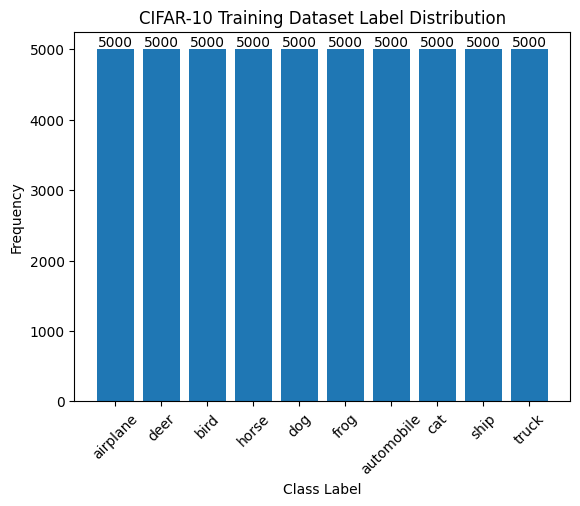

In [5]:
# Download the CIFAR-10 dataset
logging.set_verbosity_error()  # Suppress logs at the error level and below
cifar10 = load_dataset("cifar10")

# Construct histogram for training labels
all_labels = cifar10["train"]["label"]
all_label_counts = Counter(all_labels)

# Visualize the histogram
bar = plt.bar(all_label_counts.keys(), all_label_counts.values())
_ = plt.bar_label(bar)

# Plot formatting
_ = plt.xticks([label for label in all_label_counts.keys()],
               labels=["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"],
               rotation=45)

plt.xlabel("Class Label")
plt.ylabel("Frequency")
plt.title("CIFAR-10 Training Dataset Label Distribution")
plt.show()


# Model

In [6]:
class Net(nn.Module):
    def __init__(self) -> None:
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [7]:
net = Net()
num_parameters = sum(value.numel() for value in net.state_dict().values())
print(f"{num_parameters = }")

num_parameters = 62006


# train test Func


In [8]:
def train(net, trainloader, optimizer, epochs: int, verbose=False):
    """Train the network on the training set."""
    criterion = torch.nn.CrossEntropyLoss()
    net.train()
    for epoch in range(epochs):
        correct, total, epoch_loss = 0, 0, 0.0
        for batch in trainloader:
            images, labels = batch["img"].to(DEVICE), batch["label"].to(DEVICE)
            optimizer.zero_grad()
            outputs = net(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # Metrics
            epoch_loss += loss
            total += labels.size(0)
            correct += (torch.max(outputs.data, 1)[1] == labels).sum().item()

        epoch_loss /= len(trainloader.dataset)
        epoch_acc = correct / total
        if verbose:
            print(f"Epoch {epoch+1}: train loss {epoch_loss}, accuracy {epoch_acc}")


def test(net, testloader):
    """Evaluate the network on the entire test set."""
    criterion = torch.nn.CrossEntropyLoss()
    correct, total, loss = 0, 0, 0.0

    net.eval()
    with torch.no_grad():
        for batch in testloader:
            images, labels = batch["img"].to(DEVICE), batch["label"].to(DEVICE)
            outputs = net(images)

            loss += criterion(outputs, labels).item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    loss /= len(testloader.dataset)
    accuracy = correct / total
    return loss, accuracy

# centralised

In [9]:
def run_centralised(
    trainloader,
    valloader,
    testloader,
    epochs: int,
    lr: float,
    momentum: float = 0.9
):

    # instantiate the model
    model = Net().to(DEVICE)

    # optim = torch.optim.Adam(net.parameters())
    optim = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum)

    print(f"Training for {epochs} epochs...")
    train(model, trainloader, optim, epochs)
    loss, accuracy = test(model, valloader)
    print(f"validation loss {loss}, accuracy {accuracy}")

    loss, accuracy = test(model, testloader)
    print(f"{loss = }")
    print(f"{accuracy = }")

In [10]:
# Construct dataloaders
trainloader, valloader, testloader = load_datasets(partition_id=0, num_partitions=1)

# Run the centralised training
# run_centralised(trainloader, valloader, testloader, epochs=10, lr=0.01)

# Federation

## set-get params


In [11]:
def set_parameters(net, parameters: List[np.ndarray]):
    params_dict = zip(net.state_dict().keys(), parameters)
    state_dict = OrderedDict({k: torch.Tensor(v) for k, v in params_dict})
    # replace the parameters
    net.load_state_dict(state_dict, strict=True)


def get_parameters(net) -> List[np.ndarray]:
    """Extract model parameters as a list of NumPy arrays."""
    return [val.cpu().numpy() for _, val in net.state_dict().items()]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## FlowerClient

In [12]:
class FlowerClient(NumPyClient):
    def __init__(self, pid, net, trainloader, valloader):
        self.pid = pid  # partition ID of a client
        self.net = net
        self.trainloader = trainloader
        self.valloader = valloader

    def get_parameters(self, config):
        print(f"[Client {self.pid}] get_parameters")
        return get_parameters(self.net)

    def fit(self, parameters, config):
        # Read values from config
        server_round = config["server_round"]
        local_epochs = config["local_epochs"]

        # Use values provided by the config
        print(f"[Client {self.pid}, round {server_round}] fit, config: {config}")
        set_parameters(self.net, parameters)

        optim = torch.optim.SGD(self.net.parameters(), lr=0.01, momentum=0.9)
        train(self.net, self.trainloader,optim , epochs=local_epochs)

        return get_parameters(self.net), len(self.trainloader), {}

    def evaluate(self, parameters, config):

        print(f"[Client {self.pid}] evaluate, config: {config}")
        set_parameters(self.net, parameters)

        loss, accuracy = test(self.net, self.valloader)

        return float(loss), len(self.valloader), {"accuracy": float(accuracy)}


def client_fn(context: Context) -> Client:

    net = Net().to(DEVICE)

    partition_id = context.node_config["partition-id"]
    num_partitions = context.node_config["num-partitions"]

    trainloader, valloader, _ = load_datasets(partition_id, num_partitions)

    # print(f"FlowerClient is created")
    return FlowerClient(partition_id, net, trainloader, valloader).to_client()


# Create the ClientApp
client = ClientApp(client_fn=client_fn)

## Agregation Function

In [13]:
Agregation_history = []

def My_weighted_average(metrics: List[Tuple[int, Metrics]]) -> Metrics:

    accuracies = [num_examples * m["accuracy"] for num_examples, m in metrics]
    losses = [num_examples * m.get("loss", 0.0) for num_examples, m in metrics]
    examples = [num_examples for num_examples, _ in metrics]

    accuracy = sum(accuracies) / sum(examples)
    loss = sum(losses) / sum(examples)

    # Save metrics to history
    Agregation_history.append({
        # "round": server_round,
        "loss": loss,
        "accuracy": accuracy
    })

    print(f"My_weighted_average -{accuracy} {loss} ")

    return {"accuracy": accuracy, "loss": loss}

## Server Evaluate metrics aggregation fn

In [14]:
evaluation_history = []

def My_evaluate(
    server_round: int,
    parameters: NDArrays,
    config: Dict[str, Scalar],
) -> Optional[Tuple[float, Dict[str, Scalar]]]:

    net = Net().to(DEVICE)

    _, _, testloader = load_datasets(0, NUM_CLIENTS)

    set_parameters(net, parameters)  # Update model with the latest parameters

    loss, accuracy = test(net, testloader)

    print(f"Server-side evaluation loss {loss} / accuracy {accuracy}")

    # Save metrics to history
    evaluation_history.append({
        "round": server_round,
        "loss": loss,
        "accuracy": accuracy
    })

    if accuracy >= 0.98:
        print(f"Target accuracy of { 0.98*100}% achieved. Stopping training.")
        return fl.server.EarlyStopping()

    model_filename = f"federated_model_{server_round}.pth"
    torch.save(net.state_dict(), model_filename)
    print(f"Model saved as {model_filename}")

    return loss, {"accuracy": accuracy}


## Server Fn Strategy

In [15]:
def fit_config(server_round: int):
    config = {
        "server_round": server_round,  # The current round of federated learning
        "local_epochs": 5 ,
    }
    return config

In [16]:
NUM_CLIENTS = 10

In [17]:
strategy_3 = FedAdagrad(
        fraction_fit= 1,
        fraction_evaluate=0.3,
        min_fit_clients = 5,
        min_evaluate_clients = 3,
        min_available_clients = NUM_CLIENTS,
        initial_parameters = ndarrays_to_parameters(get_parameters(net)),
    )

In [18]:
NUM_ROUNDS = 30

In [19]:
params = get_parameters(Net())

In [20]:
def server_fn(context: Context) -> ServerAppComponents:
    # Create FedAvg strategy
    strategy = FedAvg(
        fraction_fit  = 1,
        fraction_evaluate = 1,
        min_fit_clients  =  5,
        min_evaluate_clients  = 2,
        min_available_clients = NUM_CLIENTS, # use all
        evaluate_fn = My_evaluate, # function used for validation dy server
        on_fit_config_fn  = fit_config,  # Pass the fit_config function
        # on_evaluate_config_fn,
        # accept_failures,
        initial_parameters  = ndarrays_to_parameters(params),
        evaluate_metrics_aggregation_fn =  My_weighted_average,
        # inplace,
    )

    config = ServerConfig(num_rounds = NUM_ROUNDS)

    return ServerAppComponents(strategy=strategy, config = config)


# Create the ServerApp
server = ServerApp(server_fn=server_fn)

## RUN


In [21]:
backend_config = {"client_resources": {"num_cpus": 1, "num_gpus": 0.0}}

run_simulation(
    server_app=server,
    client_app=client,
    num_supernodes=NUM_CLIENTS,
    backend_config=backend_config,
)

DEBUG:flwr:Asyncio event loop already running.
INFO :      Starting Flower ServerApp, config: num_rounds=30, no round_timeout
INFO :      
INFO :      [INIT]
INFO :      Using initial global parameters provided by strategy
INFO :      Starting evaluation of initial global parameters
INFO :      initial parameters (loss, other metrics): 0.07213021206855774, {'accuracy': 0.1002}
INFO :      
INFO :      [ROUND 1]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Server-side evaluation loss 0.07213021206855774 / accuracy 0.1002
Model saved as federated_model_0.pth


(pid=22752) 2024-11-17 21:27:26.552691: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
(pid=22752) 2024-11-17 21:27:26.593559: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
(pid=22751) 2024-11-17 21:27:26.705351: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
(pid=22751) 2024-11-17 21:27:29.221697: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(ClientAppActor pid=22751) /usr/local/lib/python3.10/dist-packages/jupyter_client/connect.py:28: DeprecationWarning: Jupyter is migrating its paths to use standard platformdirs
(ClientAppActor 

(ClientAppActor pid=22751) [Client 2, round 1] fit, config: {'server_round': 1, 'local_epochs': 5}
(ClientAppActor pid=22751) [Client 3, round 1] fit, config: {'server_round': 1, 'local_epochs': 5} [repeated 2x across cluster] (Ray deduplicates logs by default. Set RAY_DEDUP_LOGS=0 to disable log deduplication, or see https://docs.ray.io/en/master/ray-observability/ray-logging.html#log-deduplication for more options.)
(ClientAppActor pid=22751) [Client 7, round 1] fit, config: {'server_round': 1, 'local_epochs': 5} [repeated 2x across cluster]
(ClientAppActor pid=22751) [Client 5, round 1] fit, config: {'server_round': 1, 'local_epochs': 5} [repeated 2x across cluster]
(ClientAppActor pid=22751) [Client 0, round 1] fit, config: {'server_round': 1, 'local_epochs': 5} [repeated 2x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      fit progress: (1, 0.04957194167375564, {'accuracy': 0.4259}, 194.08429766399968)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


Server-side evaluation loss 0.04957194167375564 / accuracy 0.4259
Model saved as federated_model_1.pth
(ClientAppActor pid=22752) [Client 0] evaluate, config: {}
(ClientAppActor pid=22752) [Client 9, round 1] fit, config: {'server_round': 1, 'local_epochs': 5}
(ClientAppActor pid=22751) [Client 8] evaluate, config: {} [repeated 4x across cluster]
(ClientAppActor pid=22751) [Client 2] evaluate, config: {} [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 2]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


My_weighted_average -0.4234 0.0 
(ClientAppActor pid=22751) [Client 3, round 2] fit, config: {'server_round': 2, 'local_epochs': 5}
(ClientAppActor pid=22752) [Client 3] evaluate, config: {}
(ClientAppActor pid=22752) [Client 6, round 2] fit, config: {'server_round': 2, 'local_epochs': 5} [repeated 2x across cluster]
(ClientAppActor pid=22751) [Client 8, round 2] fit, config: {'server_round': 2, 'local_epochs': 5} [repeated 2x across cluster]
(ClientAppActor pid=22751) [Client 0, round 2] fit, config: {'server_round': 2, 'local_epochs': 5} [repeated 2x across cluster]
(ClientAppActor pid=22751) [Client 5, round 2] fit, config: {'server_round': 2, 'local_epochs': 5} [repeated 2x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      fit progress: (2, 0.04294627478122711, {'accuracy': 0.5021}, 375.6814582520001)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


Server-side evaluation loss 0.04294627478122711 / accuracy 0.5021
Model saved as federated_model_2.pth
(ClientAppActor pid=22752) [Client 0] evaluate, config: {}
(ClientAppActor pid=22752) [Client 2, round 2] fit, config: {'server_round': 2, 'local_epochs': 5}
(ClientAppActor pid=22752) [Client 8] evaluate, config: {} [repeated 4x across cluster]
(ClientAppActor pid=22751) [Client 4] evaluate, config: {} [repeated 5x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 3]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


My_weighted_average -0.5015 0.0 
(ClientAppActor pid=22752) [Client 2, round 3] fit, config: {'server_round': 3, 'local_epochs': 5}
(ClientAppActor pid=22752) [Client 3, round 3] fit, config: {'server_round': 3, 'local_epochs': 5} [repeated 2x across cluster]
(ClientAppActor pid=22751) [Client 6, round 3] fit, config: {'server_round': 3, 'local_epochs': 5} [repeated 2x across cluster]
(ClientAppActor pid=22751) [Client 4, round 3] fit, config: {'server_round': 3, 'local_epochs': 5} [repeated 2x across cluster]
(ClientAppActor pid=22751) [Client 1, round 3] fit, config: {'server_round': 3, 'local_epochs': 5} [repeated 2x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      fit progress: (3, 0.03961925381422043, {'accuracy': 0.5503}, 559.6516395709996)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


Server-side evaluation loss 0.03961925381422043 / accuracy 0.5503
Model saved as federated_model_3.pth
(ClientAppActor pid=22751) [Client 4] evaluate, config: {}
(ClientAppActor pid=22752) [Client 7, round 3] fit, config: {'server_round': 3, 'local_epochs': 5}
(ClientAppActor pid=22752) [Client 8] evaluate, config: {} [repeated 4x across cluster]
(ClientAppActor pid=22752) [Client 7] evaluate, config: {} [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 4]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


My_weighted_average -0.5523999999999999 0.0 
(ClientAppActor pid=22751) [Client 0, round 4] fit, config: {'server_round': 4, 'local_epochs': 5}
(ClientAppActor pid=22751) [Client 3] evaluate, config: {}
(ClientAppActor pid=22751) [Client 2, round 4] fit, config: {'server_round': 4, 'local_epochs': 5} [repeated 2x across cluster]
(ClientAppActor pid=22751) [Client 4, round 4] fit, config: {'server_round': 4, 'local_epochs': 5} [repeated 2x across cluster]
(ClientAppActor pid=22751) [Client 5, round 4] fit, config: {'server_round': 4, 'local_epochs': 5} [repeated 2x across cluster]
(ClientAppActor pid=22751) [Client 6, round 4] fit, config: {'server_round': 4, 'local_epochs': 5} [repeated 2x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      fit progress: (4, 0.038870618230104445, {'accuracy': 0.574}, 743.4430933129997)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


Server-side evaluation loss 0.038870618230104445 / accuracy 0.574
Model saved as federated_model_4.pth
(ClientAppActor pid=22752) [Client 0] evaluate, config: {}
(ClientAppActor pid=22752) [Client 7, round 4] fit, config: {'server_round': 4, 'local_epochs': 5}
(ClientAppActor pid=22752) [Client 9] evaluate, config: {} [repeated 4x across cluster]
(ClientAppActor pid=22752) [Client 3] evaluate, config: {} [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 5]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


My_weighted_average -0.5729 0.0 
(ClientAppActor pid=22751) [Client 0, round 5] fit, config: {'server_round': 5, 'local_epochs': 5}
(ClientAppActor pid=22751) [Client 8] evaluate, config: {}
(ClientAppActor pid=22751) [Client 2, round 5] fit, config: {'server_round': 5, 'local_epochs': 5} [repeated 2x across cluster]
(ClientAppActor pid=22751) [Client 6, round 5] fit, config: {'server_round': 5, 'local_epochs': 5} [repeated 2x across cluster]
(ClientAppActor pid=22751) [Client 9, round 5] fit, config: {'server_round': 5, 'local_epochs': 5} [repeated 2x across cluster]
(ClientAppActor pid=22751) [Client 4, round 5] fit, config: {'server_round': 5, 'local_epochs': 5} [repeated 2x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      fit progress: (5, 0.03956690509319306, {'accuracy': 0.5839}, 918.9033108009999)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


Server-side evaluation loss 0.03956690509319306 / accuracy 0.5839
Model saved as federated_model_5.pth
(ClientAppActor pid=22752) [Client 3] evaluate, config: {}
(ClientAppActor pid=22752) [Client 5, round 5] fit, config: {'server_round': 5, 'local_epochs': 5}
(ClientAppActor pid=22751) [Client 8] evaluate, config: {} [repeated 4x across cluster]
(ClientAppActor pid=22752) [Client 0] evaluate, config: {} [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 6]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


My_weighted_average -0.5854999999999999 0.0 
(ClientAppActor pid=22751) [Client 1, round 6] fit, config: {'server_round': 6, 'local_epochs': 5}
(ClientAppActor pid=22751) [Client 2] evaluate, config: {}
(ClientAppActor pid=22752) [Client 6, round 6] fit, config: {'server_round': 6, 'local_epochs': 5} [repeated 2x across cluster]
(ClientAppActor pid=22752) [Client 9, round 6] fit, config: {'server_round': 6, 'local_epochs': 5} [repeated 2x across cluster]
(ClientAppActor pid=22752) [Client 5, round 6] fit, config: {'server_round': 6, 'local_epochs': 5} [repeated 2x across cluster]
(ClientAppActor pid=22752) [Client 0, round 6] fit, config: {'server_round': 6, 'local_epochs': 5} [repeated 2x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      fit progress: (6, 0.04096959291100502, {'accuracy': 0.5878}, 1107.5168960649999)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


Server-side evaluation loss 0.04096959291100502 / accuracy 0.5878
Model saved as federated_model_6.pth
(ClientAppActor pid=22752) [Client 4] evaluate, config: {}
(ClientAppActor pid=22751) [Client 4, round 6] fit, config: {'server_round': 6, 'local_epochs': 5}
(ClientAppActor pid=22752) [Client 8] evaluate, config: {} [repeated 4x across cluster]
(ClientAppActor pid=22752) [Client 5] evaluate, config: {} [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 7]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


My_weighted_average -0.5828 0.0 
(ClientAppActor pid=22751) [Client 0, round 7] fit, config: {'server_round': 7, 'local_epochs': 5}
(ClientAppActor pid=22751) [Client 3] evaluate, config: {}
(ClientAppActor pid=22752) [Client 2, round 7] fit, config: {'server_round': 7, 'local_epochs': 5} [repeated 2x across cluster]
(ClientAppActor pid=22751) [Client 7, round 7] fit, config: {'server_round': 7, 'local_epochs': 5} [repeated 2x across cluster]
(ClientAppActor pid=22751) [Client 5, round 7] fit, config: {'server_round': 7, 'local_epochs': 5} [repeated 2x across cluster]
(ClientAppActor pid=22751) [Client 6, round 7] fit, config: {'server_round': 7, 'local_epochs': 5} [repeated 2x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      fit progress: (7, 0.043640689462423325, {'accuracy': 0.5832}, 1292.0344040680002)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


Server-side evaluation loss 0.043640689462423325 / accuracy 0.5832
Model saved as federated_model_7.pth
(ClientAppActor pid=22751) [Client 3] evaluate, config: {}
(ClientAppActor pid=22752) [Client 8, round 7] fit, config: {'server_round': 7, 'local_epochs': 5}
(ClientAppActor pid=22752) [Client 7] evaluate, config: {} [repeated 4x across cluster]
(ClientAppActor pid=22751) [Client 1] evaluate, config: {} [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 8]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


My_weighted_average -0.587 0.0 
(ClientAppActor pid=22751) [Client 2, round 8] fit, config: {'server_round': 8, 'local_epochs': 5}
(ClientAppActor pid=22752) [Client 0] evaluate, config: {}
(ClientAppActor pid=22752) [Client 5, round 8] fit, config: {'server_round': 8, 'local_epochs': 5} [repeated 2x across cluster]
(ClientAppActor pid=22751) [Client 9, round 8] fit, config: {'server_round': 8, 'local_epochs': 5} [repeated 2x across cluster]
(ClientAppActor pid=22751) [Client 3, round 8] fit, config: {'server_round': 8, 'local_epochs': 5} [repeated 2x across cluster]
(ClientAppActor pid=22751) [Client 4, round 8] fit, config: {'server_round': 8, 'local_epochs': 5} [repeated 2x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      fit progress: (8, 0.04521124165058136, {'accuracy': 0.5913}, 1480.1418154949997)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


Server-side evaluation loss 0.04521124165058136 / accuracy 0.5913
Model saved as federated_model_8.pth
(ClientAppActor pid=22752) [Client 1] evaluate, config: {}
(ClientAppActor pid=22752) [Client 1, round 8] fit, config: {'server_round': 8, 'local_epochs': 5}
(ClientAppActor pid=22752) [Client 7] evaluate, config: {} [repeated 4x across cluster]
(ClientAppActor pid=22752) [Client 0] evaluate, config: {} [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 9]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


My_weighted_average -0.592 0.0 
(ClientAppActor pid=22751) [Client 3, round 9] fit, config: {'server_round': 9, 'local_epochs': 5}
(ClientAppActor pid=22751) [Client 8] evaluate, config: {}
(ClientAppActor pid=22752) [Client 5, round 9] fit, config: {'server_round': 9, 'local_epochs': 5} [repeated 2x across cluster]
(ClientAppActor pid=22752) [Client 8, round 9] fit, config: {'server_round': 9, 'local_epochs': 5} [repeated 2x across cluster]
(ClientAppActor pid=22751) [Client 6, round 9] fit, config: {'server_round': 9, 'local_epochs': 5} [repeated 2x across cluster]
(ClientAppActor pid=22751) [Client 2, round 9] fit, config: {'server_round': 9, 'local_epochs': 5} [repeated 2x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      fit progress: (9, 0.04797728852033615, {'accuracy': 0.5809}, 1662.3724238249997)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


Server-side evaluation loss 0.04797728852033615 / accuracy 0.5809
Model saved as federated_model_9.pth
(ClientAppActor pid=22751) [Client 3] evaluate, config: {}
(ClientAppActor pid=22752) [Client 0, round 9] fit, config: {'server_round': 9, 'local_epochs': 5}
(ClientAppActor pid=22751) [Client 7] evaluate, config: {} [repeated 4x across cluster]
(ClientAppActor pid=22751) [Client 6] evaluate, config: {} [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 10]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


My_weighted_average -0.5883 0.0 
(ClientAppActor pid=22751) [Client 3, round 10] fit, config: {'server_round': 10, 'local_epochs': 5}
(ClientAppActor pid=22752) [Client 1] evaluate, config: {}
(ClientAppActor pid=22751) [Client 5, round 10] fit, config: {'server_round': 10, 'local_epochs': 5} [repeated 2x across cluster]
(ClientAppActor pid=22751) [Client 7, round 10] fit, config: {'server_round': 10, 'local_epochs': 5} [repeated 2x across cluster]
(ClientAppActor pid=22751) [Client 9, round 10] fit, config: {'server_round': 10, 'local_epochs': 5} [repeated 2x across cluster]
(ClientAppActor pid=22751) [Client 0, round 10] fit, config: {'server_round': 10, 'local_epochs': 5} [repeated 2x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      fit progress: (10, 0.05021208301186562, {'accuracy': 0.5824}, 1848.8677125969998)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


Server-side evaluation loss 0.05021208301186562 / accuracy 0.5824
Model saved as federated_model_10.pth
(ClientAppActor pid=22751) [Client 2] evaluate, config: {}
(ClientAppActor pid=22752) [Client 1, round 10] fit, config: {'server_round': 10, 'local_epochs': 5}
(ClientAppActor pid=22752) [Client 6] evaluate, config: {} [repeated 4x across cluster]
(ClientAppActor pid=22752) [Client 1] evaluate, config: {} [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 11]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


My_weighted_average -0.5896999999999999 0.0 
(ClientAppActor pid=22752) [Client 3, round 11] fit, config: {'server_round': 11, 'local_epochs': 5}
(ClientAppActor pid=22751) [Client 8] evaluate, config: {}
(ClientAppActor pid=22751) [Client 5, round 11] fit, config: {'server_round': 11, 'local_epochs': 5} [repeated 2x across cluster]
(ClientAppActor pid=22751) [Client 8, round 11] fit, config: {'server_round': 11, 'local_epochs': 5} [repeated 2x across cluster]
(ClientAppActor pid=22751) [Client 1, round 11] fit, config: {'server_round': 11, 'local_epochs': 5} [repeated 2x across cluster]
(ClientAppActor pid=22751) [Client 4, round 11] fit, config: {'server_round': 11, 'local_epochs': 5} [repeated 2x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      fit progress: (11, 0.05204330217242241, {'accuracy': 0.5826}, 2032.0161342410001)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


Server-side evaluation loss 0.05204330217242241 / accuracy 0.5826
Model saved as federated_model_11.pth
(ClientAppActor pid=22751) [Client 4] evaluate, config: {}
(ClientAppActor pid=22752) [Client 2, round 11] fit, config: {'server_round': 11, 'local_epochs': 5}
(ClientAppActor pid=22752) [Client 8] evaluate, config: {} [repeated 4x across cluster]
(ClientAppActor pid=22752) [Client 2] evaluate, config: {} [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 12]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


My_weighted_average -0.5885 0.0 
(ClientAppActor pid=22751) [Client 0, round 12] fit, config: {'server_round': 12, 'local_epochs': 5}
(ClientAppActor pid=22751) [Client 0] evaluate, config: {}
(ClientAppActor pid=22751) [Client 2, round 12] fit, config: {'server_round': 12, 'local_epochs': 5} [repeated 2x across cluster]
(ClientAppActor pid=22751) [Client 6, round 12] fit, config: {'server_round': 12, 'local_epochs': 5} [repeated 2x across cluster]
(ClientAppActor pid=22751) [Client 5, round 12] fit, config: {'server_round': 12, 'local_epochs': 5} [repeated 2x across cluster]
(ClientAppActor pid=22751) [Client 7, round 12] fit, config: {'server_round': 12, 'local_epochs': 5} [repeated 2x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      fit progress: (12, 0.05447696316242218, {'accuracy': 0.5884}, 2208.390554138)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


Server-side evaluation loss 0.05447696316242218 / accuracy 0.5884
Model saved as federated_model_12.pth
(ClientAppActor pid=22751) [Client 1] evaluate, config: {}
(ClientAppActor pid=22752) [Client 8, round 12] fit, config: {'server_round': 12, 'local_epochs': 5}
(ClientAppActor pid=22752) [Client 7] evaluate, config: {} [repeated 4x across cluster]
(ClientAppActor pid=22752) [Client 9] evaluate, config: {} [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 13]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


My_weighted_average -0.5902000000000001 0.0 
(ClientAppActor pid=22752) [Client 1, round 13] fit, config: {'server_round': 13, 'local_epochs': 5}
(ClientAppActor pid=22751) [Client 6] evaluate, config: {}
(ClientAppActor pid=22751) [Client 5, round 13] fit, config: {'server_round': 13, 'local_epochs': 5} [repeated 2x across cluster]
(ClientAppActor pid=22751) [Client 8, round 13] fit, config: {'server_round': 13, 'local_epochs': 5} [repeated 2x across cluster]
(ClientAppActor pid=22752) [Client 3, round 13] fit, config: {'server_round': 13, 'local_epochs': 5} [repeated 2x across cluster]
(ClientAppActor pid=22751) [Client 2, round 13] fit, config: {'server_round': 13, 'local_epochs': 5} [repeated 2x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      fit progress: (13, 0.056761082291603086, {'accuracy': 0.58}, 2391.471762047)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


Server-side evaluation loss 0.056761082291603086 / accuracy 0.58
Model saved as federated_model_13.pth
(ClientAppActor pid=22751) [Client 0] evaluate, config: {}
(ClientAppActor pid=22752) [Client 4, round 13] fit, config: {'server_round': 13, 'local_epochs': 5}
(ClientAppActor pid=22752) [Client 5] evaluate, config: {} [repeated 4x across cluster]
(ClientAppActor pid=22751) [Client 9] evaluate, config: {} [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 14]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


My_weighted_average -0.5861999999999999 0.0 
(ClientAppActor pid=22751) [Client 1, round 14] fit, config: {'server_round': 14, 'local_epochs': 5}
(ClientAppActor pid=22752) [Client 6] evaluate, config: {}
(ClientAppActor pid=22752) [Client 3, round 14] fit, config: {'server_round': 14, 'local_epochs': 5} [repeated 2x across cluster]
(ClientAppActor pid=22752) [Client 6, round 14] fit, config: {'server_round': 14, 'local_epochs': 5} [repeated 2x across cluster]
(ClientAppActor pid=22752) [Client 2, round 14] fit, config: {'server_round': 14, 'local_epochs': 5} [repeated 2x across cluster]
(ClientAppActor pid=22752) [Client 7, round 14] fit, config: {'server_round': 14, 'local_epochs': 5} [repeated 2x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      fit progress: (14, 0.05765930961370468, {'accuracy': 0.5827}, 2581.8815108400004)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


Server-side evaluation loss 0.05765930961370468 / accuracy 0.5827
Model saved as federated_model_14.pth
(ClientAppActor pid=22751) [Client 3] evaluate, config: {}
(ClientAppActor pid=22751) [Client 8, round 14] fit, config: {'server_round': 14, 'local_epochs': 5}
(ClientAppActor pid=22751) [Client 7] evaluate, config: {} [repeated 4x across cluster]
(ClientAppActor pid=22751) [Client 4] evaluate, config: {} [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 15]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


My_weighted_average -0.5843999999999998 0.0 
(ClientAppActor pid=22752) [Client 0, round 15] fit, config: {'server_round': 15, 'local_epochs': 5}
(ClientAppActor pid=22752) [Client 9] evaluate, config: {}
(ClientAppActor pid=22752) [Client 3, round 15] fit, config: {'server_round': 15, 'local_epochs': 5} [repeated 2x across cluster]
(ClientAppActor pid=22751) [Client 5, round 15] fit, config: {'server_round': 15, 'local_epochs': 5} [repeated 2x across cluster]
(ClientAppActor pid=22751) [Client 2, round 15] fit, config: {'server_round': 15, 'local_epochs': 5} [repeated 2x across cluster]
(ClientAppActor pid=22751) [Client 7, round 15] fit, config: {'server_round': 15, 'local_epochs': 5} [repeated 2x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      fit progress: (15, 0.060000590682029724, {'accuracy': 0.584}, 2770.7087118090003)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


Server-side evaluation loss 0.060000590682029724 / accuracy 0.584
Model saved as federated_model_15.pth
(ClientAppActor pid=22751) [Client 4] evaluate, config: {}
(ClientAppActor pid=22752) [Client 6, round 15] fit, config: {'server_round': 15, 'local_epochs': 5}
(ClientAppActor pid=22751) [Client 7] evaluate, config: {} [repeated 4x across cluster]
(ClientAppActor pid=22751) [Client 2] evaluate, config: {} [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 16]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


My_weighted_average -0.5842999999999999 0.0 
(ClientAppActor pid=22752) [Client 1, round 16] fit, config: {'server_round': 16, 'local_epochs': 5}
(ClientAppActor pid=22752) [Client 0] evaluate, config: {}
(ClientAppActor pid=22752) [Client 4, round 16] fit, config: {'server_round': 16, 'local_epochs': 5} [repeated 2x across cluster]
(ClientAppActor pid=22752) [Client 7, round 16] fit, config: {'server_round': 16, 'local_epochs': 5} [repeated 2x across cluster]
(ClientAppActor pid=22752) [Client 5, round 16] fit, config: {'server_round': 16, 'local_epochs': 5} [repeated 2x across cluster]
(ClientAppActor pid=22752) [Client 9, round 16] fit, config: {'server_round': 16, 'local_epochs': 5} [repeated 2x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      fit progress: (16, 0.06392808902859688, {'accuracy': 0.5832}, 2959.293209202)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


Server-side evaluation loss 0.06392808902859688 / accuracy 0.5832
Model saved as federated_model_16.pth
(ClientAppActor pid=22751) [Client 6] evaluate, config: {}
(ClientAppActor pid=22751) [Client 2, round 16] fit, config: {'server_round': 16, 'local_epochs': 5}
(ClientAppActor pid=22752) [Client 9] evaluate, config: {} [repeated 4x across cluster]
(ClientAppActor pid=22752) [Client 0] evaluate, config: {} [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 17]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


My_weighted_average -0.5898 0.0 
(ClientAppActor pid=22752) [Client 2, round 17] fit, config: {'server_round': 17, 'local_epochs': 5}
(ClientAppActor pid=22751) [Client 3] evaluate, config: {}
(ClientAppActor pid=22752) [Client 4, round 17] fit, config: {'server_round': 17, 'local_epochs': 5} [repeated 2x across cluster]
(ClientAppActor pid=22751) [Client 8, round 17] fit, config: {'server_round': 17, 'local_epochs': 5} [repeated 2x across cluster]
(ClientAppActor pid=22752) [Client 9, round 17] fit, config: {'server_round': 17, 'local_epochs': 5} [repeated 2x across cluster]
(ClientAppActor pid=22751) [Client 1, round 17] fit, config: {'server_round': 17, 'local_epochs': 5} [repeated 2x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      fit progress: (17, 0.06548620933890342, {'accuracy': 0.5824}, 3149.057048722)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


Server-side evaluation loss 0.06548620933890342 / accuracy 0.5824
Model saved as federated_model_17.pth
(ClientAppActor pid=22751) [Client 0] evaluate, config: {}
(ClientAppActor pid=22752) [Client 3, round 17] fit, config: {'server_round': 17, 'local_epochs': 5}
(ClientAppActor pid=22752) [Client 8] evaluate, config: {} [repeated 4x across cluster]
(ClientAppActor pid=22752) [Client 2] evaluate, config: {} [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 18]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


My_weighted_average -0.5883 0.0 
(ClientAppActor pid=22751) [Client 1, round 18] fit, config: {'server_round': 18, 'local_epochs': 5}
(ClientAppActor pid=22751) [Client 7] evaluate, config: {}
(ClientAppActor pid=22752) [Client 4, round 18] fit, config: {'server_round': 18, 'local_epochs': 5} [repeated 2x across cluster]
(ClientAppActor pid=22752) [Client 6, round 18] fit, config: {'server_round': 18, 'local_epochs': 5} [repeated 2x across cluster]
(ClientAppActor pid=22752) [Client 9, round 18] fit, config: {'server_round': 18, 'local_epochs': 5} [repeated 2x across cluster]
(ClientAppActor pid=22752) [Client 0, round 18] fit, config: {'server_round': 18, 'local_epochs': 5} [repeated 2x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      fit progress: (18, 0.06427126877307891, {'accuracy': 0.5791}, 3328.427598695999)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


Server-side evaluation loss 0.06427126877307891 / accuracy 0.5791
Model saved as federated_model_18.pth
(ClientAppActor pid=22751) [Client 1] evaluate, config: {}
(ClientAppActor pid=22751) [Client 8, round 18] fit, config: {'server_round': 18, 'local_epochs': 5}
(ClientAppActor pid=22752) [Client 7] evaluate, config: {} [repeated 4x across cluster]
(ClientAppActor pid=22752) [Client 5] evaluate, config: {} [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 19]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


My_weighted_average -0.5852 0.0 
(ClientAppActor pid=22751) [Client 0, round 19] fit, config: {'server_round': 19, 'local_epochs': 5}
(ClientAppActor pid=22751) [Client 9] evaluate, config: {}
(ClientAppActor pid=22751) [Client 4, round 19] fit, config: {'server_round': 19, 'local_epochs': 5} [repeated 2x across cluster]
(ClientAppActor pid=22752) [Client 8, round 19] fit, config: {'server_round': 19, 'local_epochs': 5} [repeated 2x across cluster]
(ClientAppActor pid=22752) [Client 6, round 19] fit, config: {'server_round': 19, 'local_epochs': 5} [repeated 2x across cluster]
(ClientAppActor pid=22752) [Client 2, round 19] fit, config: {'server_round': 19, 'local_epochs': 5} [repeated 2x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      fit progress: (19, 0.06604247241318226, {'accuracy': 0.5821}, 3515.3892760379995)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


Server-side evaluation loss 0.06604247241318226 / accuracy 0.5821
Model saved as federated_model_19.pth
(ClientAppActor pid=22751) [Client 3] evaluate, config: {}
(ClientAppActor pid=22751) [Client 1, round 19] fit, config: {'server_round': 19, 'local_epochs': 5}
(ClientAppActor pid=22752) [Client 9] evaluate, config: {} [repeated 4x across cluster]
(ClientAppActor pid=22752) [Client 7] evaluate, config: {} [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 20]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


My_weighted_average -0.5887 0.0 
(ClientAppActor pid=22751) [Client 1, round 20] fit, config: {'server_round': 20, 'local_epochs': 5}
(ClientAppActor pid=22751) [Client 2] evaluate, config: {}
(ClientAppActor pid=22751) [Client 4, round 20] fit, config: {'server_round': 20, 'local_epochs': 5} [repeated 2x across cluster]
(ClientAppActor pid=22751) [Client 8, round 20] fit, config: {'server_round': 20, 'local_epochs': 5} [repeated 2x across cluster]
(ClientAppActor pid=22751) [Client 2, round 20] fit, config: {'server_round': 20, 'local_epochs': 5} [repeated 2x across cluster]
(ClientAppActor pid=22751) [Client 7, round 20] fit, config: {'server_round': 20, 'local_epochs': 5} [repeated 2x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      fit progress: (20, 0.06874446074962616, {'accuracy': 0.5796}, 3703.5498816320005)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


Server-side evaluation loss 0.06874446074962616 / accuracy 0.5796
Model saved as federated_model_20.pth
(ClientAppActor pid=22751) [Client 1] evaluate, config: {}
(ClientAppActor pid=22752) [Client 5, round 20] fit, config: {'server_round': 20, 'local_epochs': 5}
(ClientAppActor pid=22752) [Client 9] evaluate, config: {} [repeated 4x across cluster]
(ClientAppActor pid=22751) [Client 2] evaluate, config: {} [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 21]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


My_weighted_average -0.5833999999999999 0.0 
(ClientAppActor pid=22751) [Client 3, round 21] fit, config: {'server_round': 21, 'local_epochs': 5}
(ClientAppActor pid=22752) [Client 7] evaluate, config: {}
(ClientAppActor pid=22751) [Client 4, round 21] fit, config: {'server_round': 21, 'local_epochs': 5} [repeated 2x across cluster]
(ClientAppActor pid=22751) [Client 6, round 21] fit, config: {'server_round': 21, 'local_epochs': 5} [repeated 2x across cluster]
(ClientAppActor pid=22751) [Client 0, round 21] fit, config: {'server_round': 21, 'local_epochs': 5} [repeated 2x across cluster]
(ClientAppActor pid=22751) [Client 9, round 21] fit, config: {'server_round': 21, 'local_epochs': 5} [repeated 2x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      fit progress: (21, 0.06878115547597408, {'accuracy': 0.5772}, 3892.286850379999)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


Server-side evaluation loss 0.06878115547597408 / accuracy 0.5772
Model saved as federated_model_21.pth
(ClientAppActor pid=22752) [Client 1] evaluate, config: {}
(ClientAppActor pid=22752) [Client 7, round 21] fit, config: {'server_round': 21, 'local_epochs': 5}
(ClientAppActor pid=22752) [Client 7] evaluate, config: {} [repeated 4x across cluster]
(ClientAppActor pid=22752) [Client 0] evaluate, config: {} [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 22]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


My_weighted_average -0.5817 0.0 
(ClientAppActor pid=22752) [Client 2, round 22] fit, config: {'server_round': 22, 'local_epochs': 5}
(ClientAppActor pid=22751) [Client 6] evaluate, config: {}
(ClientAppActor pid=22752) [Client 4, round 22] fit, config: {'server_round': 22, 'local_epochs': 5} [repeated 2x across cluster]
(ClientAppActor pid=22752) [Client 7, round 22] fit, config: {'server_round': 22, 'local_epochs': 5} [repeated 2x across cluster]
(ClientAppActor pid=22751) [Client 1, round 22] fit, config: {'server_round': 22, 'local_epochs': 5} [repeated 2x across cluster]
(ClientAppActor pid=22751) [Client 8, round 22] fit, config: {'server_round': 22, 'local_epochs': 5} [repeated 2x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      fit progress: (22, 0.07139839947521687, {'accuracy': 0.5761}, 4080.78360548)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


Server-side evaluation loss 0.07139839947521687 / accuracy 0.5761
Model saved as federated_model_22.pth
(ClientAppActor pid=22751) [Client 1] evaluate, config: {}
(ClientAppActor pid=22752) [Client 3, round 22] fit, config: {'server_round': 22, 'local_epochs': 5}
(ClientAppActor pid=22752) [Client 8] evaluate, config: {} [repeated 4x across cluster]
(ClientAppActor pid=22752) [Client 2] evaluate, config: {} [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 23]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


My_weighted_average -0.5807999999999999 0.0 
(ClientAppActor pid=22752) [Client 1, round 23] fit, config: {'server_round': 23, 'local_epochs': 5}
(ClientAppActor pid=22751) [Client 6] evaluate, config: {}
(ClientAppActor pid=22752) [Client 2, round 23] fit, config: {'server_round': 23, 'local_epochs': 5} [repeated 2x across cluster]
(ClientAppActor pid=22752) [Client 5, round 23] fit, config: {'server_round': 23, 'local_epochs': 5} [repeated 2x across cluster]
(ClientAppActor pid=22752) [Client 3, round 23] fit, config: {'server_round': 23, 'local_epochs': 5} [repeated 2x across cluster]
(ClientAppActor pid=22752) [Client 7, round 23] fit, config: {'server_round': 23, 'local_epochs': 5} [repeated 2x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      fit progress: (23, 0.07186894128024578, {'accuracy': 0.5775}, 4268.903321068)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


Server-side evaluation loss 0.07186894128024578 / accuracy 0.5775
Model saved as federated_model_23.pth
(ClientAppActor pid=22752) [Client 4] evaluate, config: {}
(ClientAppActor pid=22751) [Client 6, round 23] fit, config: {'server_round': 23, 'local_epochs': 5}
(ClientAppActor pid=22751) [Client 7] evaluate, config: {} [repeated 4x across cluster]
(ClientAppActor pid=22752) [Client 3] evaluate, config: {} [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 24]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


My_weighted_average -0.5802999999999999 0.0 
(ClientAppActor pid=22752) [Client 2, round 24] fit, config: {'server_round': 24, 'local_epochs': 5}
(ClientAppActor pid=22751) [Client 1] evaluate, config: {}
(ClientAppActor pid=22752) [Client 5, round 24] fit, config: {'server_round': 24, 'local_epochs': 5} [repeated 2x across cluster]
(ClientAppActor pid=22751) [Client 9, round 24] fit, config: {'server_round': 24, 'local_epochs': 5} [repeated 2x across cluster]
(ClientAppActor pid=22751) [Client 1, round 24] fit, config: {'server_round': 24, 'local_epochs': 5} [repeated 2x across cluster]
(ClientAppActor pid=22751) [Client 3, round 24] fit, config: {'server_round': 24, 'local_epochs': 5} [repeated 2x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      fit progress: (24, 0.0732579203903675, {'accuracy': 0.5788}, 4462.543057387001)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


Server-side evaluation loss 0.0732579203903675 / accuracy 0.5788
Model saved as federated_model_24.pth
(ClientAppActor pid=22751) [Client 1] evaluate, config: {}
(ClientAppActor pid=22752) [Client 6, round 24] fit, config: {'server_round': 24, 'local_epochs': 5}
(ClientAppActor pid=22751) [Client 8] evaluate, config: {} [repeated 4x across cluster]
(ClientAppActor pid=22751) [Client 5] evaluate, config: {} [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 25]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


My_weighted_average -0.5778 0.0 
(ClientAppActor pid=22752) [Client 0, round 25] fit, config: {'server_round': 25, 'local_epochs': 5}
(ClientAppActor pid=22752) [Client 7] evaluate, config: {}
(ClientAppActor pid=22752) [Client 4, round 25] fit, config: {'server_round': 25, 'local_epochs': 5} [repeated 2x across cluster]
(ClientAppActor pid=22752) [Client 8, round 25] fit, config: {'server_round': 25, 'local_epochs': 5} [repeated 2x across cluster]
(ClientAppActor pid=22752) [Client 5, round 25] fit, config: {'server_round': 25, 'local_epochs': 5} [repeated 2x across cluster]
(ClientAppActor pid=22752) [Client 6, round 25] fit, config: {'server_round': 25, 'local_epochs': 5} [repeated 2x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      fit progress: (25, 0.07349921526014805, {'accuracy': 0.5756}, 4646.320115684)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


Server-side evaluation loss 0.07349921526014805 / accuracy 0.5756
Model saved as federated_model_25.pth
(ClientAppActor pid=22751) [Client 0] evaluate, config: {}
(ClientAppActor pid=22751) [Client 3, round 25] fit, config: {'server_round': 25, 'local_epochs': 5}
(ClientAppActor pid=22751) [Client 6] evaluate, config: {} [repeated 4x across cluster]
(ClientAppActor pid=22751) [Client 1] evaluate, config: {} [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 26]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


My_weighted_average -0.5805999999999999 0.0 
(ClientAppActor pid=22751) [Client 2, round 26] fit, config: {'server_round': 26, 'local_epochs': 5}
(ClientAppActor pid=22752) [Client 2] evaluate, config: {}
(ClientAppActor pid=22751) [Client 3, round 26] fit, config: {'server_round': 26, 'local_epochs': 5} [repeated 2x across cluster]
(ClientAppActor pid=22751) [Client 7, round 26] fit, config: {'server_round': 26, 'local_epochs': 5} [repeated 2x across cluster]
(ClientAppActor pid=22751) [Client 0, round 26] fit, config: {'server_round': 26, 'local_epochs': 5} [repeated 2x across cluster]
(ClientAppActor pid=22751) [Client 5, round 26] fit, config: {'server_round': 26, 'local_epochs': 5} [repeated 2x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      fit progress: (26, 0.07457002520561218, {'accuracy': 0.5764}, 4836.3573265370005)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


Server-side evaluation loss 0.07457002520561218 / accuracy 0.5764
Model saved as federated_model_26.pth
(ClientAppActor pid=22751) [Client 4] evaluate, config: {}
(ClientAppActor pid=22752) [Client 8, round 26] fit, config: {'server_round': 26, 'local_epochs': 5}
(ClientAppActor pid=22751) [Client 8] evaluate, config: {} [repeated 4x across cluster]
(ClientAppActor pid=22752) [Client 2] evaluate, config: {} [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 27]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


My_weighted_average -0.5791999999999999 0.0 
(ClientAppActor pid=22752) [Client 2, round 27] fit, config: {'server_round': 27, 'local_epochs': 5}
(ClientAppActor pid=22751) [Client 5] evaluate, config: {}
(ClientAppActor pid=22751) [Client 4, round 27] fit, config: {'server_round': 27, 'local_epochs': 5} [repeated 2x across cluster]
(ClientAppActor pid=22751) [Client 6, round 27] fit, config: {'server_round': 27, 'local_epochs': 5} [repeated 2x across cluster]
(ClientAppActor pid=22751) [Client 0, round 27] fit, config: {'server_round': 27, 'local_epochs': 5} [repeated 2x across cluster]
(ClientAppActor pid=22751) [Client 8, round 27] fit, config: {'server_round': 27, 'local_epochs': 5} [repeated 2x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      fit progress: (27, 0.07572785207033157, {'accuracy': 0.5703}, 5032.6052146600005)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


Server-side evaluation loss 0.07572785207033157 / accuracy 0.5703
Model saved as federated_model_27.pth
(ClientAppActor pid=22752) [Client 0] evaluate, config: {}
(ClientAppActor pid=22752) [Client 9, round 27] fit, config: {'server_round': 27, 'local_epochs': 5}
(ClientAppActor pid=22752) [Client 6] evaluate, config: {} [repeated 4x across cluster]
(ClientAppActor pid=22751) [Client 4] evaluate, config: {} [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 28]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


My_weighted_average -0.5768 0.0 
(ClientAppActor pid=22751) [Client 2, round 28] fit, config: {'server_round': 28, 'local_epochs': 5}
(ClientAppActor pid=22752) [Client 9] evaluate, config: {}
(ClientAppActor pid=22751) [Client 4, round 28] fit, config: {'server_round': 28, 'local_epochs': 5} [repeated 2x across cluster]
(ClientAppActor pid=22751) [Client 7, round 28] fit, config: {'server_round': 28, 'local_epochs': 5} [repeated 2x across cluster]
(ClientAppActor pid=22751) [Client 1, round 28] fit, config: {'server_round': 28, 'local_epochs': 5} [repeated 2x across cluster]
(ClientAppActor pid=22751) [Client 3, round 28] fit, config: {'server_round': 28, 'local_epochs': 5} [repeated 2x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      fit progress: (28, 0.07652734435498715, {'accuracy': 0.5724}, 5217.625873287)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


Server-side evaluation loss 0.07652734435498715 / accuracy 0.5724
Model saved as federated_model_28.pth
(ClientAppActor pid=22752) [Client 0] evaluate, config: {}
(ClientAppActor pid=22752) [Client 5, round 28] fit, config: {'server_round': 28, 'local_epochs': 5}
(ClientAppActor pid=22751) [Client 8] evaluate, config: {} [repeated 4x across cluster]
(ClientAppActor pid=22751) [Client 4] evaluate, config: {} [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 29]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


My_weighted_average -0.5725 0.0 
(ClientAppActor pid=22751) [Client 2, round 29] fit, config: {'server_round': 29, 'local_epochs': 5}
(ClientAppActor pid=22752) [Client 9] evaluate, config: {}
(ClientAppActor pid=22752) [Client 5, round 29] fit, config: {'server_round': 29, 'local_epochs': 5} [repeated 2x across cluster]
(ClientAppActor pid=22751) [Client 6, round 29] fit, config: {'server_round': 29, 'local_epochs': 5} [repeated 2x across cluster]
(ClientAppActor pid=22752) [Client 4, round 29] fit, config: {'server_round': 29, 'local_epochs': 5} [repeated 2x across cluster]
(ClientAppActor pid=22752) [Client 9, round 29] fit, config: {'server_round': 29, 'local_epochs': 5} [repeated 2x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      fit progress: (29, 0.07898486936688423, {'accuracy': 0.5715}, 5406.669061692)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


Server-side evaluation loss 0.07898486936688423 / accuracy 0.5715
Model saved as federated_model_29.pth
(ClientAppActor pid=22751) [Client 0] evaluate, config: {}
(ClientAppActor pid=22751) [Client 1, round 29] fit, config: {'server_round': 29, 'local_epochs': 5}
(ClientAppActor pid=22752) [Client 6] evaluate, config: {} [repeated 4x across cluster]
(ClientAppActor pid=22752) [Client 9] evaluate, config: {} [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 30]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


My_weighted_average -0.5744 0.0 
(ClientAppActor pid=22751) [Client 0, round 30] fit, config: {'server_round': 30, 'local_epochs': 5}
(ClientAppActor pid=22751) [Client 1] evaluate, config: {}
(ClientAppActor pid=22751) [Client 6, round 30] fit, config: {'server_round': 30, 'local_epochs': 5} [repeated 2x across cluster]
(ClientAppActor pid=22751) [Client 7, round 30] fit, config: {'server_round': 30, 'local_epochs': 5} [repeated 2x across cluster]
(ClientAppActor pid=22752) [Client 3, round 30] fit, config: {'server_round': 30, 'local_epochs': 5} [repeated 2x across cluster]
(ClientAppActor pid=22751) [Client 1, round 30] fit, config: {'server_round': 30, 'local_epochs': 5} [repeated 2x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      fit progress: (30, 0.07618626578450204, {'accuracy': 0.5687}, 5596.889138046)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


Server-side evaluation loss 0.07618626578450204 / accuracy 0.5687
Model saved as federated_model_30.pth
(ClientAppActor pid=22751) [Client 2] evaluate, config: {}
(ClientAppActor pid=22752) [Client 9, round 30] fit, config: {'server_round': 30, 'local_epochs': 5}
(ClientAppActor pid=22751) [Client 8] evaluate, config: {} [repeated 4x across cluster]
(ClientAppActor pid=22751) [Client 6] evaluate, config: {} [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 30 round(s) in 5612.90s
INFO :      	History (loss, distributed):
INFO :      		round 1: 0.05098379262685776
INFO :      		round 2: 0.04418947134017944
INFO :      		round 3: 0.04055968804359437
INFO :      		round 4: 0.04000821300148964
INFO :      		round 5: 0.04066357983350754
INFO :      		round 6: 0.042988144296407696
INFO :      		round 7: 0.04579189878702163
INFO :      		round 8: 0.0473429092258215
INFO :      		round 9: 0.04993320191502572
INFO :      		round 10: 0.052897984069585804
INFO :      		round 11: 0.05469037201404571
INFO :      		round 12: 0.05756531379818917
INFO :      		round 13: 0.05989097936153411
INFO :      		round 14: 0.0607530384838581
INFO :      		round 15: 0.06311614289283751
INFO :      		round 16: 0.06719502581954002
INFO :      		round 17: 0.06880188249349595
INFO :      		round 18: 0.06698461433053017
INFO :      		round 19: 

My_weighted_average -0.5721999999999999 0.0 


INFO :      	              (20, 0.5796),
INFO :      	              (21, 0.5772),
INFO :      	              (22, 0.5761),
INFO :      	              (23, 0.5775),
INFO :      	              (24, 0.5788),
INFO :      	              (25, 0.5756),
INFO :      	              (26, 0.5764),
INFO :      	              (27, 0.5703),
INFO :      	              (28, 0.5724),
INFO :      	              (29, 0.5715),
INFO :      	              (30, 0.5687)]}
INFO :      


(ClientAppActor pid=22752) [Client 0] evaluate, config: {}


(ClientAppActor pid=22752) /usr/local/lib/python3.10/dist-packages/jupyter_client/connect.py:28: DeprecationWarning: Jupyter is migrating its paths to use standard platformdirs
(ClientAppActor pid=22752) given by the platformdirs library.  To remove this warning and
(ClientAppActor pid=22752) see the appropriate new directories, set the environment variable
(ClientAppActor pid=22752) `JUPYTER_PLATFORM_DIRS=1` and then run `jupyter --paths`.
(ClientAppActor pid=22752) The use of platformdirs will be the default in `jupyter_core` v6
(ClientAppActor pid=22752)   from jupyter_core.paths import jupyter_data_dir, jupyter_runtime_dir, secure_write


## Metrics

In [22]:
Agregation_history

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[{'loss': 0.0, 'accuracy': 0.4234},
 {'loss': 0.0, 'accuracy': 0.5015},
 {'loss': 0.0, 'accuracy': 0.5523999999999999},
 {'loss': 0.0, 'accuracy': 0.5729},
 {'loss': 0.0, 'accuracy': 0.5854999999999999},
 {'loss': 0.0, 'accuracy': 0.5828},
 {'loss': 0.0, 'accuracy': 0.587},
 {'loss': 0.0, 'accuracy': 0.592},
 {'loss': 0.0, 'accuracy': 0.5883},
 {'loss': 0.0, 'accuracy': 0.5896999999999999},
 {'loss': 0.0, 'accuracy': 0.5885},
 {'loss': 0.0, 'accuracy': 0.5902000000000001},
 {'loss': 0.0, 'accuracy': 0.5861999999999999},
 {'loss': 0.0, 'accuracy': 0.5843999999999998},
 {'loss': 0.0, 'accuracy': 0.5842999999999999},
 {'loss': 0.0, 'accuracy': 0.5898},
 {'loss': 0.0, 'accuracy': 0.5883},
 {'loss': 0.0, 'accuracy': 0.5852},
 {'loss': 0.0, 'accuracy': 0.5887},
 {'loss': 0.0, 'accuracy': 0.5833999999999999},
 {'loss': 0.0, 'accuracy': 0.5817},
 {'loss': 0.0, 'accuracy': 0.5807999999999999},
 {'loss': 0.0, 'accuracy': 0.5802999999999999},
 {'loss': 0.0, 'accuracy': 0.5778},
 {'loss': 0.0, 'ac

In [23]:
evaluation_history

[{'round': 0, 'loss': 0.07213021206855774, 'accuracy': 0.1002},
 {'round': 1, 'loss': 0.04957194167375564, 'accuracy': 0.4259},
 {'round': 2, 'loss': 0.04294627478122711, 'accuracy': 0.5021},
 {'round': 3, 'loss': 0.03961925381422043, 'accuracy': 0.5503},
 {'round': 4, 'loss': 0.038870618230104445, 'accuracy': 0.574},
 {'round': 5, 'loss': 0.03956690509319306, 'accuracy': 0.5839},
 {'round': 6, 'loss': 0.04096959291100502, 'accuracy': 0.5878},
 {'round': 7, 'loss': 0.043640689462423325, 'accuracy': 0.5832},
 {'round': 8, 'loss': 0.04521124165058136, 'accuracy': 0.5913},
 {'round': 9, 'loss': 0.04797728852033615, 'accuracy': 0.5809},
 {'round': 10, 'loss': 0.05021208301186562, 'accuracy': 0.5824},
 {'round': 11, 'loss': 0.05204330217242241, 'accuracy': 0.5826},
 {'round': 12, 'loss': 0.05447696316242218, 'accuracy': 0.5884},
 {'round': 13, 'loss': 0.056761082291603086, 'accuracy': 0.58},
 {'round': 14, 'loss': 0.05765930961370468, 'accuracy': 0.5827},
 {'round': 15, 'loss': 0.0600005906

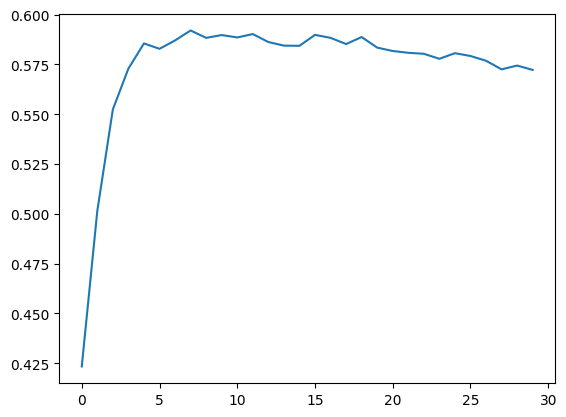

In [24]:
accuracy_values = [d['accuracy'] for d in Agregation_history]
plt.plot(accuracy_values)
plt.show()

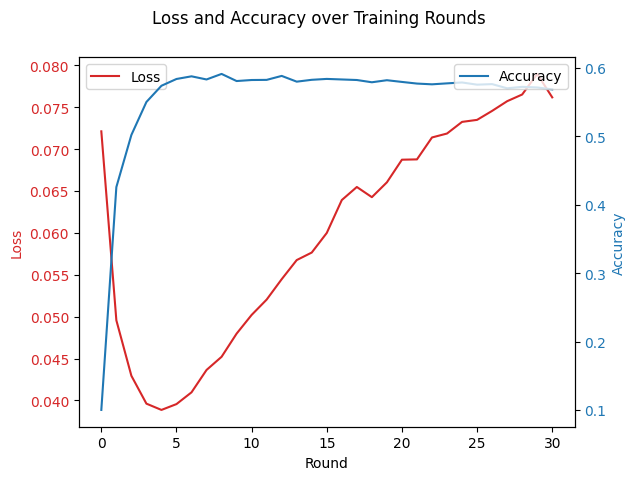

In [25]:
rounds = [entry["round"] for entry in evaluation_history]
loss = [entry["loss"] for entry in evaluation_history]
accuracy = [entry["accuracy"] for entry in evaluation_history]

fig, ax1 = plt.subplots()

# Plot loss on the first y-axis
ax1.set_xlabel("Round")
ax1.set_ylabel("Loss", color="tab:red")
ax1.plot(rounds, loss, color="tab:red", label="Loss")
ax1.tick_params(axis="y", labelcolor="tab:red")

# Create a second y-axis for accuracy
ax2 = ax1.twinx()
ax2.set_ylabel("Accuracy", color="tab:blue")
ax2.plot(rounds, accuracy, color="tab:blue", label="Accuracy")
ax2.tick_params(axis="y", labelcolor="tab:blue")

# Title and legend
fig.suptitle("Loss and Accuracy over Training Rounds")
ax1.legend(loc="upper left")
ax2.legend(loc="upper right")

# Show the plot
plt.show()
